# ART Adversarial Patch attack

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install Imagenet stubs to have some image examples
import sys
!{sys.executable} -m pip install git+https://github.com/nottombrown/imagenet_stubs

import random
import numpy as np
import tensorflow as tf
sess = tf.InteractiveSession()
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label
import warnings
warnings.filterwarnings('ignore')

from art.classifiers.tensorflow import TFClassifier
from art.attacks import AdversarialPatch

  Cloning https://github.com/nottombrown/imagenet_stubs to /home/irina.nicolae/tmp/pip-req-build-2j3b9h26
  Stored in directory: /home/irina.nicolae/tmp/pip-ephem-wheel-cache-pd_p0wcs/wheels/ae/51/e7/c1cfa8692ea864410aa778b169fc7766af073ac52a1bc23301
Successfully built imagenet-stubs


# Settings

In [2]:
target_image_name = 'toaster.jpg'
patch_shape = (224, 224, 3)
image_shape = (224, 224, 3)
batch_size = 3
scale_min = 0.3
scale_max = 1.0
rotation_max = 22.5
learning_rate = 200000.0
max_iter = 1000

# Model definition

In [3]:
_image_input = tf.keras.Input(shape=image_shape)
_target_ys = tf.placeholder(tf.float32, shape=(None, 1000))
model = tf.keras.applications.resnet50.ResNet50(input_tensor=_image_input, weights='imagenet')
_logits = model.outputs[0].op.inputs[0]
target_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=_target_ys, logits=_logits))

tfc = TFClassifier(clip_values=(0, 1), input_ph=_image_input, output_ph=_target_ys, logits=_logits,
                   sess=sess, loss=target_loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



# Imagenet training images

In [4]:
images_list = list()
target_image = None

for image_path in imagenet_stubs.get_image_paths():
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    im = preprocess_input(im)
    
    if image_path.endswith(target_image_name):
        target_image = im
    else:
        images_list.append(im)

images = random.sample(images_list, batch_size)
images = np.concatenate(images, axis=0)

# Adversarial patch generation

In [5]:
ap = AdversarialPatch(classifier=tfc, target=name_to_label('toaster'), rotation_max=rotation_max, scale_min=scale_min,
                      scale_max=scale_max, learning_rate=learning_rate, max_iter=max_iter, patch_shape=patch_shape,
                      batch_size=batch_size, clip_patch=[(-103.939, 255.0 - 103.939), (-116.779, 255.0 - 116.779), (-123.680, 255.0 - 123.680)])
patch, patch_mask = ap.generate(x=images)

In [6]:
def from_keras(x):
    x = np.copy(x)
    x[:, :, 2] += 123.68
    x[:, :, 1] += 116.779
    x[:, :, 0] += 103.939
    return x[:, :, [2, 1, 0]].astype(np.uint8)

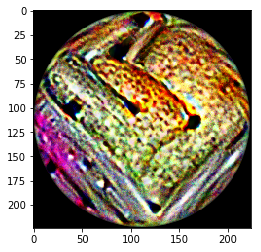

In [7]:
plt.imshow((from_keras(patch) * patch_mask).astype(np.uint))

# Evaluation

In [8]:
patched_images = ap.apply_patch(images, scale=0.5)

In [9]:
def predict_model(model, image):
    plt.imshow((from_keras(image)).astype(np.uint))
    plt.show()
    
    image = np.copy(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    
    prediction = model.predict(image)
    
    top = 3
    prediction_decode = decode_predictions(prediction, top=top)[0]
    print('Predictions:')
    
    lengths = list()
    for i in range(top):
        lengths.append(len(prediction_decode[i][1]))
    max_length = max(lengths)
    
    for i in range(top):
        name = prediction_decode[i][1]
        name = name.ljust(max_length, " ")
        probability = prediction_decode[i][2]
        output_str = "{} {:.2f}".format(name, probability)
        print(output_str)

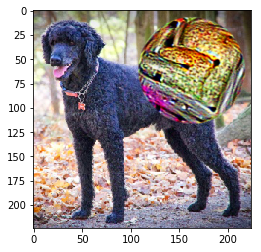

Predictions:
standard_poodle        0.46
curly-coated_retriever 0.35
miniature_poodle       0.15


In [10]:
predict_model(model, patched_images[0, :, :, :])

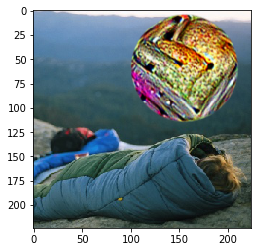

Predictions:
toaster    0.98
dumbbell   0.00
piggy_bank 0.00


In [11]:
predict_model(model, patched_images[1, :, :, :])

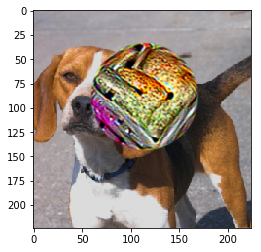

Predictions:
toaster  0.54
revolver 0.14
dumbbell 0.07


In [12]:
predict_model(model, patched_images[2, :, :, :])